In [0]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data.sampler import  SubsetRandomSampler
from torch import optim
from torch.autograd import Variable

from PIL import Image

In [0]:
batch_size = 64
valid_size = 0.2
num_workers= 4

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5],
                         [0.5, 0.5, 0.5])
  ])

train_data = datasets.MNIST(root='data', train=True,
                           download=True, transform=transform)

test_data = datasets.MNIST(root='data', train=False,
                           download=True, transform=transform)

num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]


train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)


train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)

valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
    sampler=valid_sampler, num_workers=num_workers)

test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
    num_workers=num_workers)

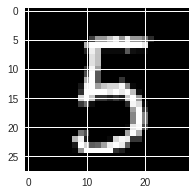

In [52]:
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

# get one image from the batch
img = np.squeeze(images[0])

fig = plt.figure(figsize = (3,3)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')

In [0]:
class WhyteNetwork(nn.Module):
  
  def __init__(self):
    
    super(WhyteNetwork, self).__init__()
    
    hidden_1 = 258
    hidden_2 = 128
    hidden_3 = 64
    
    #The first convolution layer with 16 feature map
    self.conv1 = nn.Conv2d(1, 16, 3, padding=1)
    #The secound convolutional layer with 32 fature map
    self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
    #The is maxpooling layer it help to reduce the x and y dimension of the output
    #image size of the secound convolution layer
    self.maxpool = nn.MaxPool2d(2,2)
    
    self.fc_1 = nn.Linear(32*7*7, hidden_1)
    self.fc_2 = nn.Linear(hidden_1, hidden_2)
    self.fc_3 = nn.Linear(hidden_2, hidden_3)
    self.fc_4 = nn.Linear(hidden_3, 10)
    
    #Here implemented dropout for the fully connected layers because it help the
    #to reduce the dead relu problems
    self.dropout1 = nn.Dropout(p = 0.2)
    self.dropout2 = nn.Dropout(p = 0.4)
    self.dropout3 = nn.Dropout(p = 0.2)
    
      
  def forward(self, x):
    
    x = F.relu(self.conv1(x))
    x = self.maxpool(x)
    x = self.maxpool(F.relu(self.conv2(x)))
    
    x = x.view(-1, 32*7*7)
    x = self.dropout1(F.relu(self.fc_1(x)))
    x = self.dropout2(F.relu(self.fc_2(x)))
    x = self.dropout3(F.relu(self.fc_3(x)))
    x = F.log_softmax(self.fc_4(x), dim=1)
    
    return x
    

In [54]:
model = WhyteNetwork().cuda()
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

print(model)

WhyteNetwork(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc_1): Linear(in_features=1568, out_features=258, bias=True)
  (fc_2): Linear(in_features=258, out_features=128, bias=True)
  (fc_3): Linear(in_features=128, out_features=64, bias=True)
  (fc_4): Linear(in_features=64, out_features=10, bias=True)
  (dropout1): Dropout(p=0.2)
  (dropout2): Dropout(p=0.4)
  (dropout3): Dropout(p=0.2)
)


In [55]:
# number of epochs to train the model
n_epochs = 30

# initialize tracker for minimum validation loss
valid_loss_min = np.Inf # set initial "min" to infinity

for epoch in range(n_epochs):
    # monitor training loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model.train() # prep model for training
    for data, target in train_loader:
        data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item()*data.size(0)
        
    ######################    
    # validate the model #
    ######################
    model.eval() # prep model for evaluation
    for data, target in valid_loader:
        data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update running validation loss 
        valid_loss += loss.item()*data.size(0)
        
    # print training/validation statistics 
    # calculate average loss over an epoch
    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = valid_loss/len(valid_loader.dataset)
    
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch+1, 
        train_loss,
        valid_loss
        ))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'childrenModel.pt')
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 0.478653 	Validation Loss: 0.045936
Validation loss decreased (inf --> 0.045936).  Saving model ...
Epoch: 2 	Training Loss: 0.172541 	Validation Loss: 0.027342
Validation loss decreased (0.045936 --> 0.027342).  Saving model ...
Epoch: 3 	Training Loss: 0.119284 	Validation Loss: 0.020257
Validation loss decreased (0.027342 --> 0.020257).  Saving model ...
Epoch: 4 	Training Loss: 0.101778 	Validation Loss: 0.018270
Validation loss decreased (0.020257 --> 0.018270).  Saving model ...
Epoch: 5 	Training Loss: 0.088948 	Validation Loss: 0.017604
Validation loss decreased (0.018270 --> 0.017604).  Saving model ...
Epoch: 6 	Training Loss: 0.076659 	Validation Loss: 0.017158
Validation loss decreased (0.017604 --> 0.017158).  Saving model ...
Epoch: 7 	Training Loss: 0.068974 	Validation Loss: 0.015618
Validation loss decreased (0.017158 --> 0.015618).  Saving model ...
Epoch: 8 	Training Loss: 0.066904 	Validation Loss: 0.014002
Validation loss decreased (0.01561

In [0]:
#Here is a function that helps to load in our checkpoint
def load_checkpoint(filepath):
  
    checkpoint = torch.load(filepath)
    model.load_state_dict(checkpoint)

    return model

In [0]:
#Here i will load in my checkpoint the code here
model = load_checkpoint('childrenModel.pt')

In [58]:
#The code below is used to test the performance of the model on the test data

# initialize lists to monitor test loss and accuracy
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval() # prep model for evaluation

for data, target in test_loader:
    data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
    # compare predictions to true label
    correct = np.squeeze(pred.eq(target.data.view_as(pred)))
    # calculate test accuracy for each object class
    for i in range(16):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# calculate and print avg test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            str(i), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.045507

Test Accuracy of     0: 100% (241/241)
Test Accuracy of     1: 98% (285/288)
Test Accuracy of     2: 97% (256/263)
Test Accuracy of     3: 98% (257/261)
Test Accuracy of     4: 98% (267/270)
Test Accuracy of     5: 96% (209/216)
Test Accuracy of     6: 97% (218/223)
Test Accuracy of     7: 99% (261/263)
Test Accuracy of     8: 99% (222/223)
Test Accuracy of     9: 97% (258/264)

Test Accuracy (Overall): 98% (2474/2512)


In [0]:
#The function below helps to process the image so it can be passed to the model
def process_image(img_path, max_size=28, shape=None):
    ''' Load in and transform an image, making sure the image
       is = 28 pixels in the x-y dims.'''
    
    image = Image.open(img_path).convert('LA')
    
    # large images will slow down processing
    if max(image.size) > max_size:
        size = max_size
    else:
        size = max(image.size)
    
    if shape is not None:
        size = shape
        
    in_transform = transforms.Compose([
                        transforms.Resize(size),
                        transforms.ToTensor(),
                        transforms.Normalize((0.5, 0.5, 0.5), 
                                             (0.5, 0.5, 0.5))])

    # discard the transparent, alpha channel (that's the :1) and add the batch dimension
    image = in_transform(image)[:1,:,:].unsqueeze(0)
    
    return image

In [0]:
#The function here helps to get prediction from the model
def predict(image_path, model, topk_value):
  
    image = process_image(image_path, shape=(28, 28))
    image = image.type(torch.FloatTensor)
    model = model.type(torch.FloatTensor)
    model.eval()
    logps = model(image).to(device)
    ps = torch.exp(logps)
    probs, classes = ps.topk(topk_value, dim=1)
    probs = Variable(probs, requires_grad= False)
    probs = probs.type(torch.FloatTensor).numpy().squeeze()
    classes = Variable(classes, requires_grad = False)
    classes = classes.type(torch.FloatTensor).numpy().squeeze()

    return probs, classes

In [0]:
#The function here helps to plot the predicted results for visulization purposes
def display_images(image_path, model, topk_value):
    probs, classes = predict(image_path, model, topk_value)
    disp_image = Image.open(image_path)
    
    fig = plt.figure(figsize=(5, 10))

    ax1 = fig.add_subplot(211)
    ax1.imshow(disp_image)
    ax1.axis('off')
    ax1.set_title(image_path)
    ax2 = fig.add_subplot(212)

    ax2_label = []
    for name in classes:
        ax2_label.append(str(int(name)))
    ax2.barh(ax2_label, probs)

    return plt.show()

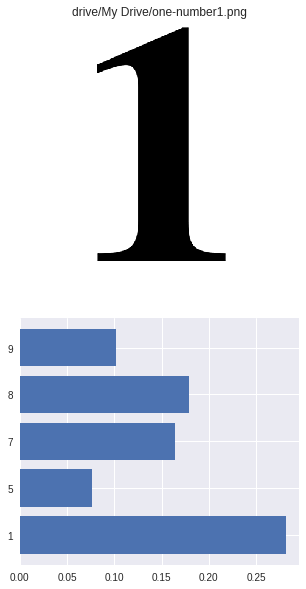

In [62]:
display_images('drive/My Drive/one-number1.png', model, 5)